In [1]:
import datetime
import sys

sys.path.append("../nflpp")

import dataprep
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance

In [ ]:
pbp_data = dataprep.load_pbp_data(range(1999, 2024))

print(f"Play-by-play data shape: {pbp_data.shape}")

In [3]:
processed_data = pbp_data[pbp_data["play_type"].isin(["run", "pass"])]

print(f"Run/pass filtered shape: {processed_data.shape}")

Run/pass filtered shape: (839562, 390)


In [5]:
processed_data.loc[:, "poscoach"] = processed_data.apply(
    lambda row: row["home_coach"]
    if row["posteam"] == row["home_team"]
    else row["away_coach"],
    axis=1,
)

print(f"Post-poscoach shape: {processed_data.shape}")

Post-poscoach shape: (839562, 391)


In [5]:
for column in ("posteam", "poscoach", "play_type"):
    processed_data[column] = LabelEncoder().fit_transform(processed_data[column])

In [6]:
train_data = processed_data[processed_data["season"] < 2022]
test_data = processed_data[processed_data["season"] == 2022]
validation_data = processed_data[processed_data["season"] == 2023]

In [7]:
columns = [
    "drive",
    "qtr",
    "quarter_seconds_remaining",
    "down",
    "ydstogo",
    "yardline_100",
    "shotgun",
    "no_huddle",
    "score_differential",
    "spread_line",
    "season",
    "poscoach",
    "posteam",
]

clf = XGBClassifier()
clf.fit(train_data[columns].values, train_data["play_type"])
test_preds = clf.predict(test_data[columns].values)
accuracy = accuracy_score(test_data["play_type"], test_preds)
accuracy

0.7233982500705617

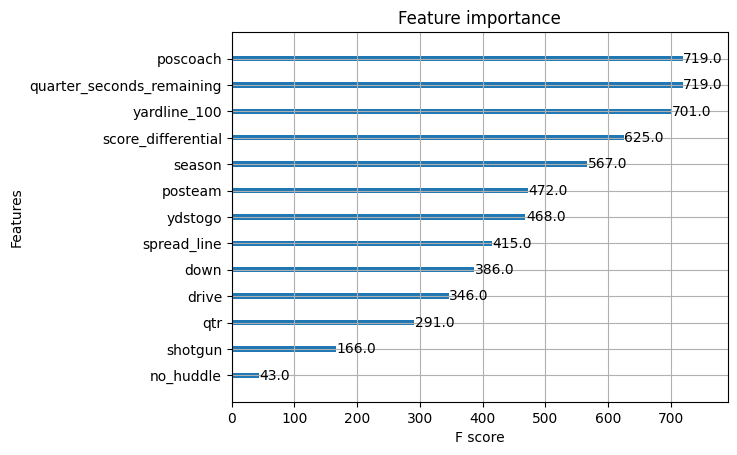

In [8]:
clf.get_booster().feature_names = columns

plot_importance(clf)
plt.show()

In [9]:
models_directory = "../models"

version = 3
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"{models_directory}/xgboost_v{version}_{timestamp}_{accuracy:.4f}.json"

clf.save_model(filename)